In [2]:
#access to api stuff
from data_loaders import loadAllCommunityMembers
import random
import numpy as np
from pandas import DataFrame
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
def getUniformVkIds(random_ids_count = 100000):
    end_point = 38573152
    step = 38573152 / random_ids_count
    position = random.randint(1,100)
    ids = []
    while position + step + 100 < end_point:
        ids.append(position)
        position += step + random.randint(-100,100)
    return ids


In [4]:
#load users info
nf_sbp_info = loadAllCommunityMembers("satyrabezsortyra",max_users = 100000)
nf_nod_info = loadAllCommunityMembers("rusnod",max_users = 100000)
nf_ros_info = loadAllCommunityMembers("rospil",max_users = 100000)
nf_star_info = loadAllCommunityMembers("nstarikov_club",max_users = 100000)
nf_unusers_info = loadAllCommunityMembers("unifirmselectedusers",user_ids = getUniformVkIds())

In [5]:
def infoToDf(group_name,users_info):
    df=DataFrame(users_info)
    df['group'] = group_name
    return df

sbp_df  = infoToDf("satyrabezsortyra",nf_sbp_info)
nod_df  = infoToDf("rusnod",nf_nod_info)
ros_df  = infoToDf("rospil",nf_ros_info)
star_df = infoToDf("nstarikov_club",nf_star_info)
unusers_df = infoToDf("unifirmselectedusers",nf_unusers_info)

data = pd.concat([sbp_df,nod_df,ros_df,star_df,unusers_df])

In [6]:
def isPOI(uinfo):
    return "age" in uinfo and uinfo["age"]>17 and uinfo["age"]<53 and uinfo["deactivated"] == "" and uinfo["hidden"] == ""
data = data[data.apply(isPOI,axis=1)]

In [7]:
common_citizens_count = {u"Москва":20062882,u"Санкт-Петербург":9507955,
        u"Екатеринбург":3071128,u"Нижний Новгород":1453112,
        u"Ростов-на-Дону":1445124,u"Новосибирск":2703574,
        u"Челябинск":1829236,u"Уфа":1824041,u"Казань":2815375,
        u"Красноярск":1575066,u"Самара":2136336,u"Воронеж":875462,
        u"Киев":4777192,u"Пермь":1680500,u"Омск":1455939,
        u"Краснодар":2598059,u"Тюмень":761405,
        u"Калининград":860368,u"Тула":394480,u"Тверь":367132,u'Харьков':1700272,
        u'Донецк':1000000,u'Кривой Рог':622095,u'Севастополь':404954,u'Минск':1431908,u'Одесса':1421276}
def plot_cities(data):
    fig = plt.figure(figsize = (17,18))
    fig.suptitle("Cities",fontsize=20)
    groups = data['group'].unique()
    row_n = math.ceil(1.0*len(groups)/2)
    for group_num,group in enumerate(groups):
        group_data = data[ data['group'] == group ]
        citezen_count = group_data.groupby('city').size()
        citezen_count.sort(ascending = False)
        citezen_count = citezen_count[:10].reset_index()
        citezen_count[0] = citezen_count.apply(lambda x: float(x[0])/common_citizens_count[x['city']],axis=1)
        summa = citezen_count[0].sum()
        citezen_count[0] = citezen_count[0]/summa
        ax = fig.add_subplot(row_n,2,group_num+1)
        ax.set_title(group)
        sns.barplot(x=0, y="city", data=citezen_count, ax=ax)
    plt.show()
    
def plot_age(data):
    fig = plt.figure(figsize = (17,18))
    fig.suptitle("Cities",fontsize=20)
    groups = data['group'].unique()
    row_n = math.ceil(1.0*len(groups)/2)
    for group_num,group in enumerate(groups):
        group_data = data[ data['group'] == group ]
        ax = fig.add_subplot(row_n,2,group_num+1)
        ax.set_title(group)
        sns.distplot(group_data['age'],ax=ax,kde=True,bins=len(group_data['age'].unique()) )
    plt.show()
    
def plot_age_by_cities(data):
    fig = plt.figure(figsize = (17,21))
    fig.suptitle("Age by cities",fontsize=20)
    groups = data['group'].unique()
    row_n = math.ceil(1.0*len(groups)/2)
    for group_num,group in enumerate(groups):
        top_cities = data[ data['group'] == group ].groupby('city').size()
        top_cities.sort(ascending = False)
        top_cities = top_cities[:10]
        ax = sns.violinplot(ax=fig.add_subplot(row_n,2,group_num+1),x="city", y="age", hue="sex",order = top_cities.index  ,data=data[(data['group'] == group) & (data['city'].isin(list(top_cities.index))) ], split=True)
        ax.set_title(group)
        sns.plt.xticks(rotation=30)
    sns.plt.show()
    
def plot_top_by_group(field,data):
    groups = data['group'].unique()
    data_for_ploting = []
    for group in groups:
        group_data = DataFrame({ field: reduce(lambda x, y: x+y, [ row[1] for row in data[data['group'] == group][field].dropna().iteritems() ],[]) })
        group_data = group_data.groupby(field).size()
        group_data.sort(ascending = False)
        group_data = group_data[:15]
        group_data = group_data.reset_index().rename(columns={0: "persent"})
        group_data['group']=group
        group_data['persent'] = group_data['persent']/data[data['group'] == group].shape[0]
        data_for_ploting.append(group_data)
        
    fig = plt.figure(figsize = (12,12))
    fig.suptitle("Age by cities",fontsize=20)
    data_for_ploting = pd.concat(data_for_ploting)
    ax = sns.barplot(ax = fig.add_subplot(1,1,1),x='persent', y=field, hue="group", data=data_for_ploting)
    sns.plt.show()
    

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:60: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


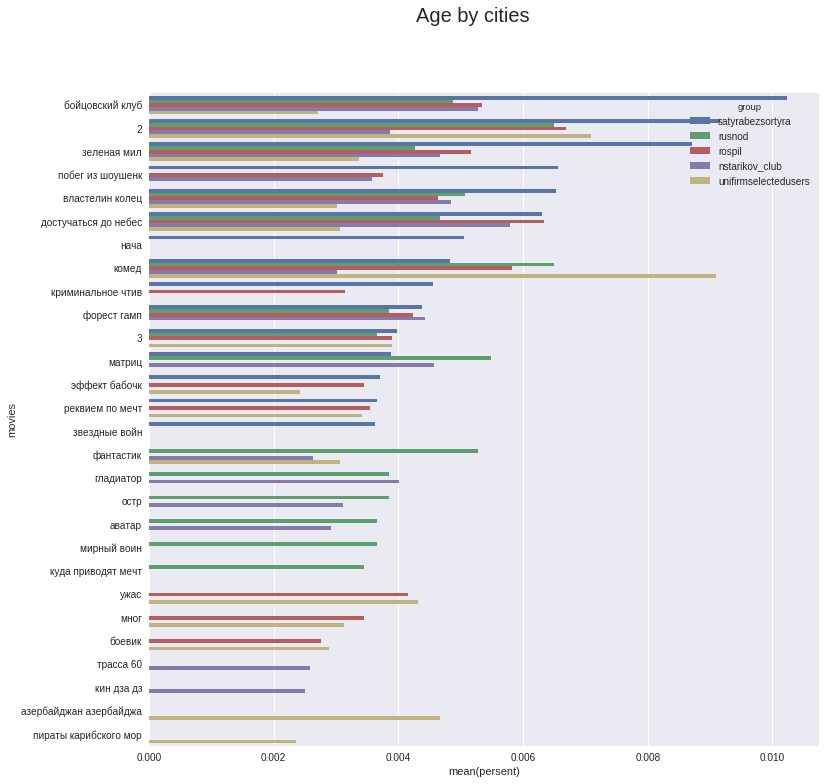

In [13]:
plot_top_by_group('movies',data)

In [20]:
all_field_values = DataFrame({ 'book': reduce(lambda x, y: x+y, [ row[1] for row in data['books'].dropna().iteritems() ],[]) })

In [25]:
all_field_values_c = all_field_values.groupby('book').size()
all_field_values_c.sort()
all_field_values_c = all_field_values_c.reset_index().rename(columns={0: "count"})

,book,count
0,мастер и маргарит,449
1,фантастик,243
2,достоевск,192
3,булгак,166
4,библ,157
5,мног,154
6,нет,154
7,детектив,150
8,властелин колец,149
9,война и мир,135


TypeError: unsupported operand type(s) for /: 'str' and 'int'

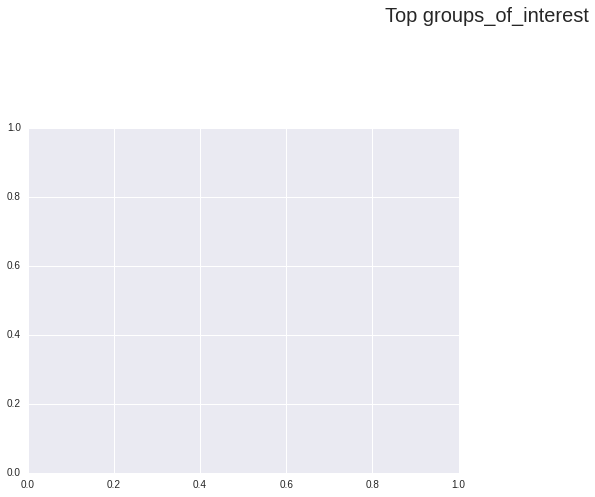

In [49]:

plot_top_by_group('groups_of_interest',data)
#plot_age(data)
'''
plot_cities(data)

plot_age_by_cities(data)
'''
#data.head()
#data.books.dropna().iterrows()groups_of_interest

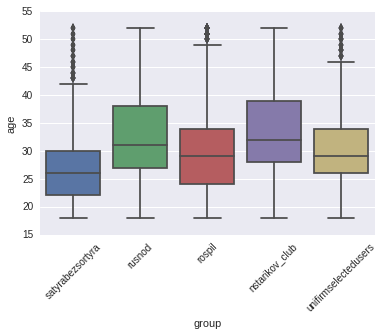

In [33]:
bp = sns.boxplot(data = data, x='group',y='age' )
plt.xticks(rotation=45)
sns.plt.show()